# Detection of GPS and IMU Spoofing in Autonomous Systems (Research-style Notebook)

**Author:** Badrudeen Yusuf Akinkunmi  
**Date:** 2025-08-11

**Abstract:**  
This notebook demonstrates an end-to-end research-style pipeline for detecting GPS (GNSS) spoofing using synthetic GNSS + IMU data. We generate realistic synthetic trajectories, inject configurable spoofing events (abrupt jumps and gradual drifts), extract physics-informed features, and train two supervised classifiers — **XGBoost** and **Random Forest** — for spoof detection. For completeness we also include an optional LSTM Autoencoder section (unsupervised) and an appendix explaining how to plug in real datasets (Kaggle/Oxford RobotCar, TEXBAT).

**Notebook notes:**  
- Plots and metrics are produced only when code cells are executed.  
- The notebook is Colab-ready; pip install commands are commented where appropriate.  


## 1. Introduction

GPS spoofing is the intentional transmission of counterfeit GNSS signals to deceive a receiver about its true position or time. For autonomous vehicles, successful spoofing can cause incorrect navigation, unsafe maneuvers, or loss of situational awareness.

This notebook explores:
- Synthetic data generation for safe, repeatable experiments.
- Feature engineering combining GNSS and IMU signals.
- Supervised learning comparison (XGBoost vs Random Forest).
- Optional unsupervised anomaly detection with an LSTM Autoencoder.
- A simple mitigation demonstration that reduces reliance on GNSS when spoofing is detected.


In [1]:
# === Setup & Imports ===
# Uncomment the install line in Colab if packages are not already available:
# !pip install xgboost scikit-learn pandas numpy matplotlib seaborn torch --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
import os

sns.set(style='whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


## 2. Methodology (Overview)

**Synthetic data generation**
- Create a smooth random-walk "true" trajectory (latitude, longitude).
- Create GNSS-reported coordinates by adding small receiver noise.
- Inject spoofing in configurable windows:
  - Abrupt jump (large instantaneous offset).
  - Gradual drift (small offset accumulating over time).
- Create simple IMU proxies (accelerometer and gyroscope signals) that remain *truthful* (not spoofed).

**Feature engineering**
- GNSS displacement (meters) between consecutive samples.
- INS proxy displacement (from speed).
- Residuals between GNSS and INS-derived displacement.
- Rolling statistics (mean/std) of displacement.
- Synthetic SNR and satellite count features.

**Models**
- XGBoost classifier (supervised).
- Random Forest classifier (supervised).
- Optional LSTM Autoencoder for unsupervised anomaly detection.

**Mitigation (demo)**
- A toy fusion that reduces trust in GNSS when detector flags spoofing (visual demonstration).


In [2]:
# === Synthetic GNSS + IMU Generator ===
def generate_synthetic_gnss_imu(n_points=2000,
                                spoof_windows=[(400,480),(1100,1180),(1600,1680)],
                                abrupt_prob=0.6):
    """Generate synthetic GNSS+IMU dataframe with configurable spoof windows."""
    deg_to_m = 111320
    # True trajectory (small random walk)
    lat = 51.75 + np.cumsum(np.random.normal(0, 0.00002, n_points))
    lon = -1.25 + np.cumsum(np.random.normal(0, 0.00002, n_points))
    # per-step displacement approx (meters)
    dlat = np.concatenate([[0], np.diff(lat)])
    dlon = np.concatenate([[0], np.diff(lon)])
    disp_m = np.sqrt((dlat*deg_to_m)**2 + (dlon*deg_to_m*np.cos(np.deg2rad(lat)))**2)
    speed = np.clip(disp_m, 0, None)  # proxy for per-timestep motion
    heading = (np.degrees(np.arctan2(dlon, np.where(dlat==0, 1e-9, dlat))) + 360) % 360
    # IMU proxies
    accel = np.concatenate([[0], np.diff(speed)]) + np.random.normal(0,0.02,n_points)
    gyro = np.concatenate([[0], np.diff(heading)]) + np.random.normal(0,0.1,n_points)
    # GNSS reported (true + receiver noise)
    gnss_lat = lat + np.random.normal(0, 1e-5, n_points)
    gnss_lon = lon + np.random.normal(0, 1e-5, n_points)
    spoofed = np.zeros(n_points, dtype=int)
    # Inject spoofing windows
    for (s,e) in spoof_windows:
        length = e - s
        if np.random.rand() < abrupt_prob:
            lat_off = np.random.normal(0.0009, 0.0003)
            lon_off = np.random.normal(-0.0009, 0.0003)
            gnss_lat[s:e] += lat_off
            gnss_lon[s:e] += lon_off
        else:
            gnss_lat[s:e] += np.linspace(0, 0.0012, length) + np.random.normal(0, 2e-5, length)
            gnss_lon[s:e] += np.linspace(0, -0.0012, length) + np.random.normal(0, 2e-5, length)
        spoofed[s:e] = 1
    # synthetic SNR and satellite count
    snr = 30 + np.random.normal(0,1,n_points)
    snr[spoofed==1] += np.random.normal(2.0,0.8, spoofed.sum())
    sat_count = np.random.randint(6,12,n_points)
    df = pd.DataFrame({
        'time': np.arange(n_points),
        'true_lat': lat, 'true_lon': lon,
        'gnss_lat': gnss_lat, 'gnss_lon': gnss_lon,
        'speed': speed, 'heading': heading,
        'imu_ax': accel, 'imu_gyro': gyro,
        'snr': snr, 'sat_count': sat_count,
        'spoofed': spoofed
    })
    return df

# Generate default dataset
df = generate_synthetic_gnss_imu()
print('Synthetic dataset created:', df.shape)
df.head()


Synthetic dataset created: (2000, 12)


,time,true_lat,true_lon,gnss_lat,gnss_lon,speed,heading,imu_ax,imu_gyro,snr,sat_count,spoofed
0,0,51.750010,-1.250014,51.750010,-1.250020,0.000000,0.000000,-0.017270,-0.111408,30.806360,6,0
1,1,51.750007,-1.250016,51.750002,-1.250019,0.366660,226.267016,0.366036,226.203923,29.355485,6,0
2,2,51.750020,-1.250032,51.750018,-1.250038,1.808971,309.261025,1.442670,82.899803,28.590451,10,0
3,3,51.750051,-1.250038,51.750058,-1.250037,3.417339,348.568740,1.617821,39.252915,30.079070,11,0
4,4,51.750046,-1.250076,51.750059,-1.250064,2.661616,262.950920,-0.783060,-85.639235,30.700073,9,0


### Feature Engineering

We extract the following features per time step:
- **GNSS displacement (meters)** between consecutive GNSS samples.
- **INS displacement proxy** from speed.
- **Residual**: GNSS_disp - INS_disp (useful to detect inconsistency).
- **Rolling mean/std** of GNSS displacement (windows = 3,5,11).
- **SNR** and **satellite count** (synthetic here).
- **Heading change** magnitude.


In [3]:
# === Feature extraction ===
def extract_features(df):
    d = df.copy()
    deg_to_m = 111320
    d['dlat_g'] = d['gnss_lat'].diff().fillna(0)
    d['dlon_g'] = d['gnss_lon'].diff().fillna(0)
    d['dlat_m_g'] = d['dlat_g'] * deg_to_m
    d['dlon_m_g'] = d['dlon_g'] * deg_to_m * np.cos(np.deg2rad(d['gnss_lat']))
    d['disp_m_g'] = np.sqrt(d['dlat_m_g']**2 + d['dlon_m_g']**2)
    d['disp_m_ins'] = d['speed']
    d['disp_residual'] = d['disp_m_g'] - d['disp_m_ins']
    for w in [3,5,11]:
        d[f'disp_mean_{w}'] = d['disp_m_g'].rolling(w, min_periods=1).mean()
        d[f'disp_std_{w}'] = d['disp_m_g'].rolling(w, min_periods=1).std().fillna(0)
    d['dheading'] = np.abs(np.diff(np.pad(d['heading'].values,(1,0),'edge')))
    features = ['gnss_lat','gnss_lon','speed','heading','disp_m_g','disp_m_ins',
                'disp_residual','disp_mean_3','disp_std_3','disp_mean_5','disp_std_5',
                'snr','sat_count','dheading']
    features = [f for f in features if f in d.columns]
    X = d[features].fillna(0)
    y = d['spoofed'].astype(int).values
    return X, y

X, y = extract_features(df)
print('Features shape:', X.shape)
X.head()


Features shape: (2000, 14)


,gnss_lat,gnss_lon,speed,heading,disp_m_g,disp_m_ins,disp_residual,disp_mean_3,disp_std_3,disp_mean_5,disp_std_5,snr,sat_count,dheading
0,51.750010,-1.250020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.806360,6,0.000000
1,51.750002,-1.250019,0.366660,226.267016,0.833742,0.366660,0.467081,0.416871,0.589544,0.416871,0.589544,29.355485,6,226.267016
2,51.750018,-1.250038,1.808971,309.261025,2.225267,1.808971,0.416297,1.019670,1.124225,1.019670,1.124225,28.590451,10,82.994009
3,51.750058,-1.250037,3.417339,348.568740,4.378859,3.417339,0.961520,2.479289,1.786158,1.859467,1.914060,30.079070,11,39.307715
4,51.750059,-1.250064,2.661616,262.950920,1.864085,2.661616,-0.797531,2.822737,1.359687,1.860391,1.657626,30.700073,9,85.617820


## Model Training

We split the data into train/test (80/20) stratified by the spoof label, then train:
- **XGBoost** (gradient-boosted trees) — fast + strong baseline.
- **Random Forest** — ensemble of decision trees, robust and interpretable.

We will compare metrics (accuracy, precision, recall, F1-score, ROC-AUC) and confusion matrices.


In [4]:
# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED, stratify=y)

# XGBoost (no deprecated param)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:,1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=RANDOM_SEED)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:,1]

print('Training complete.')

Training complete.


## Results & Comparison

Below we compute standard classification metrics and present a comparison table for XGBoost vs Random Forest.


In [5]:
# === Metrics computation ===
def compute_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    return {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1, 'roc_auc': auc}

xgb_metrics = compute_metrics(y_test, xgb_pred, xgb_proba)
rf_metrics = compute_metrics(y_test, rf_pred, rf_proba)
metrics_df = pd.DataFrame([xgb_metrics, rf_metrics], index=['XGBoost','RandomForest'])
metrics_df


,accuracy,precision,recall,f1,roc_auc
XGBoost,1.00,1.0,1.000000,1.000000,1.000000
RandomForest,0.99,1.0,0.916667,0.956522,0.999467


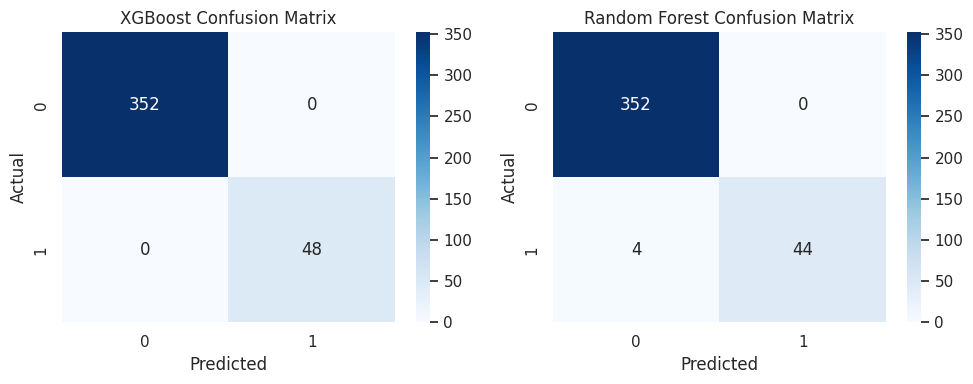

In [6]:
# === Confusion Matrices ===
fig, axs = plt.subplots(1,2, figsize=(10,4))
cm_x = confusion_matrix(y_test, xgb_pred)
cm_r = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_x, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('XGBoost Confusion Matrix'); axs[0].set_xlabel('Predicted'); axs[0].set_ylabel('Actual')
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Random Forest Confusion Matrix'); axs[1].set_xlabel('Predicted'); axs[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()


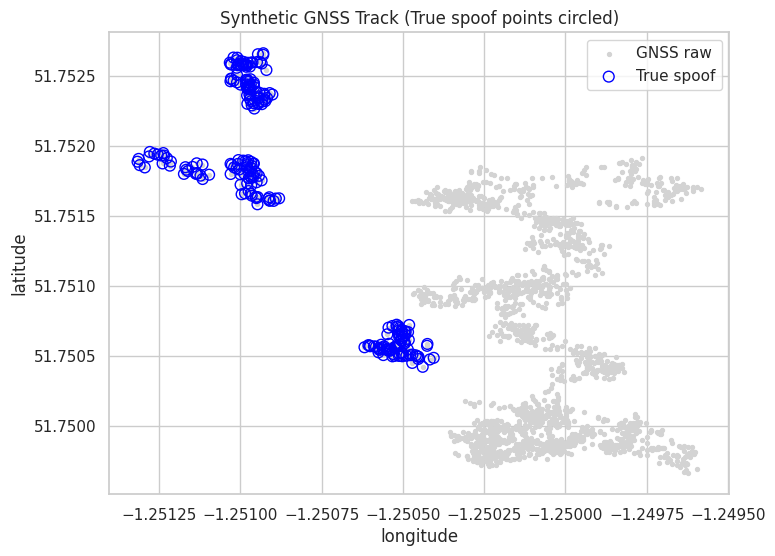

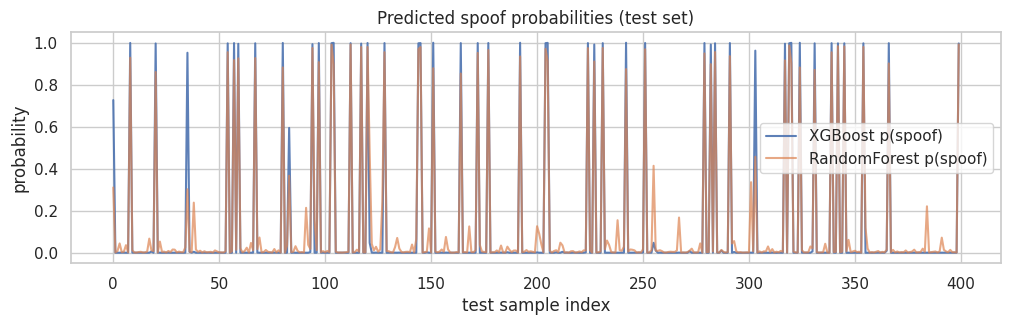

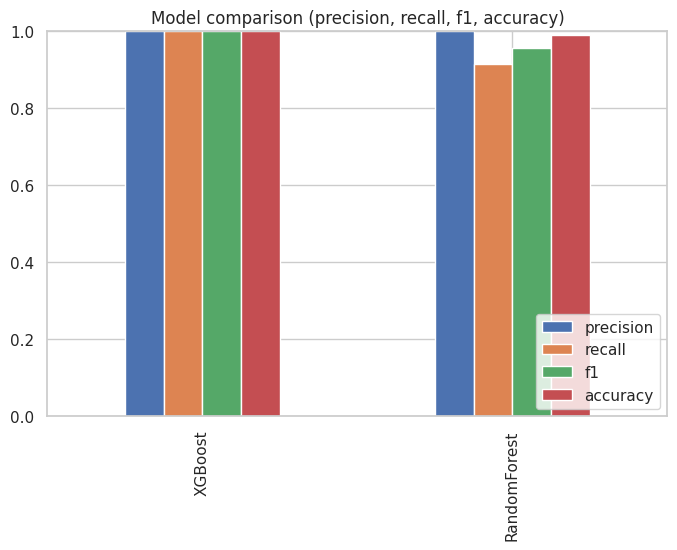

In [7]:
# === Visualizations ===
# 1) GNSS track with true spoof points
plt.figure(figsize=(8,6))
plt.scatter(df['gnss_lon'], df['gnss_lat'], c='lightgray', s=8, label='GNSS raw')
plt.scatter(df.loc[df['spoofed']==1,'gnss_lon'], df.loc[df['spoofed']==1,'gnss_lat'], facecolors='none', edgecolors='blue', s=60, label='True spoof')
plt.title('Synthetic GNSS Track (True spoof points circled)'); plt.xlabel('longitude'); plt.ylabel('latitude')
plt.legend(); plt.show()

# 2) Model probabilities on test set (aligned by index)
plt.figure(figsize=(12,3))
plt.plot(xgb_proba, label='XGBoost p(spoof)', alpha=0.9)
plt.plot(rf_proba, label='RandomForest p(spoof)', alpha=0.7)
plt.title('Predicted spoof probabilities (test set)'); plt.legend(); plt.xlabel('test sample index'); plt.ylabel('probability')
plt.show()

# 3) Bar chart comparison of metrics
metrics_to_plot = metrics_df[['precision','recall','f1','accuracy']]
metrics_to_plot.plot(kind='bar', figsize=(8,5))
plt.title('Model comparison (precision, recall, f1, accuracy)')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()


## Optional: LSTM Autoencoder (Unsupervised) — Brief

Below is an optional section to train a sequence LSTM autoencoder on *clean* windows and use reconstruction error as an anomaly score. This is useful when labeled spoof examples are scarce.

Run the cell if you want to include an unsupervised detector in addition to the two supervised models.


In [8]:
# === Optional LSTM Autoencoder (train only if desired) ===
do_ae = True  # set False to skip the autoencoder section
if do_ae:
    # Prepare scaled sequences
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    SEQ = 20
    def create_sequences(Xarr, seq_len=SEQ):
        seqs = []
        for i in range(len(Xarr)-seq_len+1):
            seqs.append(Xarr[i:i+seq_len])
        return np.stack(seqs)
    clean_mask = (y==0)
    X_clean_seq = create_sequences(X_scaled[clean_mask], SEQ)
    if X_clean_seq.shape[0] < 10:
        X_clean_seq = create_sequences(X_scaled, SEQ)  # fallback
    train_tensor = torch.tensor(X_clean_seq, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=64, shuffle=True)
    # Define a small LSTM AE
    class LSTMAE(nn.Module):
        def __init__(self, n_features, hidden=64, latent=16):
            super().__init__()
            self.enc = nn.LSTM(n_features, hidden, batch_first=True)
            self.enc_fc = nn.Linear(hidden, latent)
            self.dec_fc = nn.Linear(latent, hidden)
            self.dec = nn.LSTM(hidden, n_features, batch_first=True)
        def forward(self, x):
            out, _ = self.enc(x)
            h = out[:, -1, :]
            z = self.enc_fc(h)
            dec_in = self.dec_fc(z).unsqueeze(1).repeat(1, x.size(1), 1)
            out_dec, _ = self.dec(dec_in)
            return out_dec
    ae = LSTMAE(X.shape[1])
    opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    # Train briefly
    ae.train()
    EPOCHS = 15
    for epoch in range(EPOCHS):
        tot = 0
        for (batch,) in train_loader:
            opt.zero_grad()
            rec = ae(batch)
            loss = loss_fn(rec, batch)
            loss.backward()
            opt.step()
            tot += loss.item()
        if (epoch+1) % 5 == 0 or epoch==0:
            print(f'Epoch {epoch+1}/{EPOCHS}, loss={tot/len(train_loader):.6f}')
    # compute errors across dataset
    X_all_seq = create_sequences(X_scaled, SEQ)
    with torch.no_grad():
        ae.eval()
        rec_all = ae(torch.tensor(X_all_seq, dtype=torch.float32)).numpy()
    rec_err = np.mean((rec_all - X_all_seq)**2, axis=(1,2))
    # map to per-sample
    err_per_sample = np.zeros(len(X_scaled)); counts = np.zeros(len(X_scaled))
    for i,e in enumerate(rec_err):
        err_per_sample[i:i+SEQ] += e
        counts[i:i+SEQ] += 1
    err_per_sample /= np.maximum(counts, 1)
    thr_ae = np.percentile(err_per_sample[clean_mask], 95) if np.any(clean_mask) else np.percentile(err_per_sample, 95)
    print('AE threshold (95pct on clean):', thr_ae)
else:
    print('Skipping AE section.')

Epoch 1/15, loss=0.716895
Epoch 5/15, loss=0.628190
Epoch 10/15, loss=0.616348
Epoch 15/15, loss=0.623117
AE threshold (95pct on clean): 1.1536749026634958


## Appendix: Using Real Datasets (optional)

If you want to run these experiments with real-world datasets (e.g., Oxford RobotCar, TEXBAT), follow these steps:

1. Obtain dataset access (Kaggle or direct download).
2. Preprocess: extract GNSS NMEA logs or receiver CSVs with per-satellite SNR, HDOP, timestamp, and IMU logs.
3. Replace the synthetic data generator with a loader that produces a DataFrame matching the columns used in this notebook:  
   `['time','true_lat','true_lon','gnss_lat','gnss_lon','speed','heading','imu_ax','imu_gyro','snr','sat_count','spoofed']`
4. Re-run feature extraction and model training.

**Legal & safety note:** Do not broadcast spoofed GNSS signals outside a shielded lab. Use recorded traces or GNSS simulators.


## Conclusion

This notebook provides a research-style, reproducible pipeline for exploring GPS spoofing detection.  
You can extend it by:
- Using real GNSS + IMU datasets and richer GNSS metadata (carrier-phase, pseudorange residuals).
- Implementing a proper EKF/UKF for mitigation.
- Testing transferability across environments (urban canyon, highway) and adversary types.
